<a href="https://colab.research.google.com/github/rkmad/pytorch_experiments/blob/main/PyTorch_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch experimentation with FMNIST dataset

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [3]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:00<00:00, 119850450.51it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 111627486.53it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 68346648.59it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7100387.04it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



In [4]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)

    return x

model = FMNIST()

In [5]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

#Track train loss, test loss, and accuracy across epochs


In [6]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 30
train_tracker, test_tracker, accuracy_tracker = [], [], []

for i in range(num_epochs):
    cum_loss = 0

    for batch, (images, labels) in enumerate(trainloader,1):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()

    train_tracker.append(cum_loss/len(trainloader))
    print(f"Epoch({i+1}/{num_epochs}) | Train loss: {cum_loss/len(trainloader)} | ",end='')

    test_loss = 0
    num_correct = 0
    total = 0

    for batch, (images, labels) in enumerate(testloader,1):
        images = images.to(device)
        labels = labels.to(device)

        logps = model(images)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        output = torch.exp(logps)
        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()

    test_tracker.append(test_loss/len(testloader))
    print(f"Test loss: {test_loss/len(testloader)} | ", end='')
    accuracy_tracker.append(num_correct/total)
    print(f'Accuracy: {num_correct/total}')
print(f'\nNumber correct : {num_correct}, Total : {total}')
print(f'Accuracy of the model after 30 epochs on the 10000 test images: {num_correct * 100 / total}% ')

Epoch(1/30) | Train loss: 1.0341349766770405 | Test loss: 0.6526547850696904 | Accuracy : 0.7516
Epoch(2/30) | Train loss: 0.5618628569122063 | Test loss: 0.5530102336482637 | Accuracy : 0.8017
Epoch(3/30) | Train loss: 0.49154420781618496 | Test loss: 0.5239408477476448 | Accuracy : 0.8075
Epoch(4/30) | Train loss: 0.4571522805037529 | Test loss: 0.4832161597575352 | Accuracy : 0.8249
Epoch(5/30) | Train loss: 0.4337335761422033 | Test loss: 0.4522694729885478 | Accuracy : 0.8362
Epoch(6/30) | Train loss: 0.4154982076747331 | Test loss: 0.47644228388549414 | Accuracy : 0.825
Epoch(7/30) | Train loss: 0.4020653751962729 | Test loss: 0.44492712882673663 | Accuracy : 0.8378
Epoch(8/30) | Train loss: 0.38920502981016125 | Test loss: 0.4228949540170135 | Accuracy : 0.8486
Epoch(9/30) | Train loss: 0.37834086014962653 | Test loss: 0.43029787453116886 | Accuracy : 0.8439
Epoch(10/30) | Train loss: 0.370012295589264 | Test loss: 0.4053164839175097 | Accuracy : 0.8527
Epoch(11/30) | Train loss

#Conclusions
Accuracy increases nearly monotonically over epochs

Below, plot train loss, test loss, and accuracy over 30 epochs.

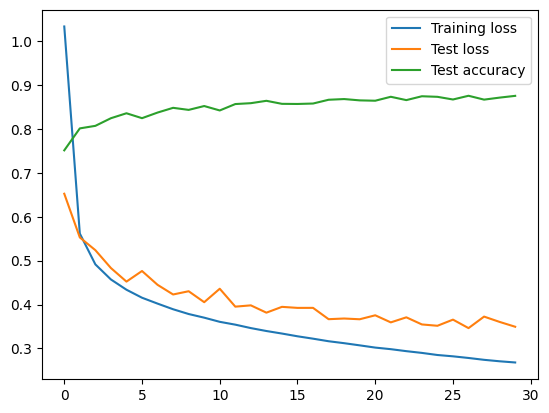

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.plot(accuracy_tracker, label='Test accuracy')
plt.legend()

## Further experiments
- TEst adding more layers? e.g. https://pytorch.org/docs/master/nn.html#torch.nn.Dropout
- Change number of nodes in the layers?
- Change number of epochs?